# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-15 10:29:58.762146: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 10:29:59.390853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 35
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("basic_english")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2049990
Valid Tokens:  214417
Test Tokens:  241859
Total number of tokens: 2506266


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 28785


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 34.825785



H_LSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 2343/2343 [05:02<00:00,  7.76batch/s, loss=6.39, perplexity=786]    


Valid: Loss = 5.745 Perplexity= 322.2, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 2343/2343 [05:13<00:00,  7.48batch/s, loss=5.83, perplexity=351]


Valid: Loss = 5.486 Perplexity= 249.2, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=5.57, perplexity=273]


Valid: Loss = 5.328 Perplexity= 213.2, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 2343/2343 [05:14<00:00,  7.45batch/s, loss=5.35, perplexity=218]


Valid: Loss = 5.158 Perplexity= 180.3, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 2343/2343 [05:10<00:00,  7.54batch/s, loss=5.13, perplexity=177]


Valid: Loss = 4.974 Perplexity= 150.2, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 2343/2343 [05:10<00:00,  7.55batch/s, loss=4.9, perplexity=140] 


Valid: Loss = 4.773 Perplexity= 123.1, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 2343/2343 [05:10<00:00,  7.54batch/s, loss=4.68, perplexity=112]


Valid: Loss = 4.569 Perplexity= 100.1, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=4.49, perplexity=92.8]


Valid: Loss = 4.427 Perplexity= 87.3, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 2343/2343 [05:12<00:00,  7.51batch/s, loss=4.31, perplexity=77.7]


Valid: Loss = 4.297 Perplexity= 76.55, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 2343/2343 [05:16<00:00,  7.40batch/s, loss=4.15, perplexity=66.1]


Valid: Loss = 4.13 Perplexity= 64.78, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 2343/2343 [05:23<00:00,  7.24batch/s, loss=4.01, perplexity=57.2]


Valid: Loss = 3.993 Perplexity= 56.43, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 2343/2343 [05:19<00:00,  7.33batch/s, loss=3.87, perplexity=49.9]


Valid: Loss = 3.879 Perplexity= 50.34, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 2343/2343 [05:13<00:00,  7.48batch/s, loss=3.74, perplexity=43.8]


Valid: Loss = 3.794 Perplexity= 46.22, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 2343/2343 [05:15<00:00,  7.42batch/s, loss=3.63, perplexity=39]  


Valid: Loss = 3.662 Perplexity= 40.51, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 2343/2343 [05:17<00:00,  7.37batch/s, loss=3.51, perplexity=34.9]


Valid: Loss = 3.563 Perplexity= 36.67, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 2343/2343 [05:13<00:00,  7.47batch/s, loss=3.4, perplexity=31]   


Valid: Loss = 3.465 Perplexity= 33.25, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 2343/2343 [05:05<00:00,  7.67batch/s, loss=3.3, perplexity=28.2] 


Valid: Loss = 3.36 Perplexity= 29.94, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 2343/2343 [05:11<00:00,  7.52batch/s, loss=3.21, perplexity=25.6]


Valid: Loss = 3.312 Perplexity= 28.55, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 2343/2343 [05:07<00:00,  7.62batch/s, loss=3.13, perplexity=23.6]


Valid: Loss = 3.223 Perplexity= 26.12, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 2343/2343 [04:55<00:00,  7.94batch/s, loss=3.03, perplexity=21.4]


Valid: Loss = 3.128 Perplexity= 23.72, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 2343/2343 [05:01<00:00,  7.77batch/s, loss=2.95, perplexity=19.8]


Valid: Loss = 3.064 Perplexity= 22.27, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 2343/2343 [04:47<00:00,  8.14batch/s, loss=2.88, perplexity=18.3]


Valid: Loss = 3.02 Perplexity= 21.32, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 2343/2343 [05:10<00:00,  7.54batch/s, loss=2.81, perplexity=17.1]


Valid: Loss = 2.961 Perplexity= 20.07, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 2343/2343 [04:57<00:00,  7.87batch/s, loss=2.75, perplexity=16.2]


Valid: Loss = 2.888 Perplexity= 18.63, LR = 0.5
Model Saved!



Epoch 24: 100%|██████████| 2343/2343 [05:08<00:00,  7.60batch/s, loss=2.69, perplexity=15.1]


Valid: Loss = 2.989 Perplexity= 20.62, LR = 0.5



Epoch 25: 100%|██████████| 2343/2343 [05:13<00:00,  7.48batch/s, loss=2.38, perplexity=11.1]


Valid: Loss = 2.499 Perplexity= 12.65, LR = 0.25
Model Saved!



Epoch 26: 100%|██████████| 2343/2343 [05:05<00:00,  7.66batch/s, loss=2.26, perplexity=9.83]


Valid: Loss = 2.452 Perplexity= 12.08, LR = 0.25
Model Saved!



Epoch 27: 100%|██████████| 2343/2343 [05:16<00:00,  7.41batch/s, loss=2.2, perplexity=9.29] 


Valid: Loss = 2.39 Perplexity= 11.34, LR = 0.25
Model Saved!



Epoch 28: 100%|██████████| 2343/2343 [05:08<00:00,  7.58batch/s, loss=2.15, perplexity=8.83]


Valid: Loss = 2.384 Perplexity= 11.26, LR = 0.25
Model Saved!



Epoch 29: 100%|██████████| 2343/2343 [05:11<00:00,  7.52batch/s, loss=2.11, perplexity=8.46]


Valid: Loss = 2.333 Perplexity= 10.68, LR = 0.25
Model Saved!



Epoch 30: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=2.07, perplexity=8.14]


Valid: Loss = 2.314 Perplexity= 10.48, LR = 0.25
Model Saved!



Epoch 31: 100%|██████████| 2343/2343 [05:11<00:00,  7.52batch/s, loss=2.04, perplexity=7.85]


Valid: Loss = 2.259 Perplexity= 9.93, LR = 0.25
Model Saved!



Epoch 32: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=2, perplexity=7.55]   


Valid: Loss = 2.22 Perplexity= 9.541, LR = 0.25
Model Saved!



Epoch 33: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=1.97, perplexity=7.3] 


Valid: Loss = 2.235 Perplexity= 9.674, LR = 0.25



Epoch 34: 100%|██████████| 2343/2343 [04:45<00:00,  8.20batch/s, loss=1.73, perplexity=5.79]


Valid: Loss = 1.957 Perplexity= 7.318, LR = 0.125
Model Saved!



Epoch 35: 100%|██████████| 2343/2343 [04:56<00:00,  7.90batch/s, loss=1.66, perplexity=5.39]


Valid: Loss = 1.918 Perplexity= 7.037, LR = 0.125
Model Saved!



Epoch 36: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=1.63, perplexity=5.18]


Valid: Loss = 1.904 Perplexity= 6.933, LR = 0.125
Model Saved!



Epoch 37: 100%|██████████| 2343/2343 [05:11<00:00,  7.51batch/s, loss=1.59, perplexity=5.01]


Valid: Loss = 1.87 Perplexity= 6.703, LR = 0.125
Model Saved!



Epoch 38: 100%|██████████| 2343/2343 [05:02<00:00,  7.76batch/s, loss=1.57, perplexity=4.89]


Valid: Loss = 1.846 Perplexity= 6.543, LR = 0.125
Model Saved!



Epoch 39: 100%|██████████| 2343/2343 [04:58<00:00,  7.84batch/s, loss=1.54, perplexity=4.77]


Valid: Loss = 1.831 Perplexity= 6.44, LR = 0.125
Model Saved!



Epoch 40: 100%|██████████| 2343/2343 [04:48<00:00,  8.12batch/s, loss=1.53, perplexity=4.69]


Valid: Loss = 1.803 Perplexity= 6.262, LR = 0.125
Model Saved!



Epoch 41: 100%|██████████| 2343/2343 [04:55<00:00,  7.94batch/s, loss=1.5, perplexity=4.57] 


Valid: Loss = 1.793 Perplexity= 6.195, LR = 0.125
Model Saved!



Epoch 42: 100%|██████████| 2343/2343 [05:07<00:00,  7.63batch/s, loss=1.48, perplexity=4.48]


Valid: Loss = 1.782 Perplexity= 6.13, LR = 0.125
Model Saved!



Epoch 43: 100%|██████████| 2343/2343 [04:54<00:00,  7.95batch/s, loss=1.47, perplexity=4.41]


Valid: Loss = 1.775 Perplexity= 6.088, LR = 0.125
Model Saved!



Epoch 44: 100%|██████████| 2343/2343 [05:01<00:00,  7.77batch/s, loss=1.45, perplexity=4.32]


Valid: Loss = 1.731 Perplexity= 5.82, LR = 0.125
Model Saved!



Epoch 45: 100%|██████████| 2343/2343 [04:52<00:00,  8.02batch/s, loss=1.43, perplexity=4.26]


Valid: Loss = 1.74 Perplexity= 5.878, LR = 0.125



Epoch 46: 100%|██████████| 2343/2343 [05:14<00:00,  7.45batch/s, loss=1.28, perplexity=3.66]


Valid: Loss = 1.573 Perplexity= 4.963, LR = 0.0625
Model Saved!



Epoch 47: 100%|██████████| 2343/2343 [04:47<00:00,  8.15batch/s, loss=1.24, perplexity=3.5] 


Valid: Loss = 1.543 Perplexity= 4.812, LR = 0.0625
Model Saved!



Epoch 48: 100%|██████████| 2343/2343 [05:02<00:00,  7.75batch/s, loss=1.22, perplexity=3.44]


Valid: Loss = 1.519 Perplexity= 4.698, LR = 0.0625
Model Saved!



Epoch 49: 100%|██████████| 2343/2343 [05:13<00:00,  7.47batch/s, loss=1.21, perplexity=3.39]


Valid: Loss = 1.504 Perplexity= 4.625, LR = 0.0625
Model Saved!



Epoch 50: 100%|██████████| 2343/2343 [05:13<00:00,  7.46batch/s, loss=1.19, perplexity=3.34]


Valid: Loss = 1.508 Perplexity= 4.644, LR = 0.0625



Epoch 51: 100%|██████████| 2343/2343 [05:13<00:00,  7.47batch/s, loss=1.13, perplexity=3.12]


Valid: Loss = 1.392 Perplexity= 4.129, LR = 0.03125
Model Saved!



Epoch 52: 100%|██████████| 2343/2343 [05:09<00:00,  7.56batch/s, loss=1.1, perplexity=3.05] 


Valid: Loss = 1.377 Perplexity= 4.062, LR = 0.03125
Model Saved!



Epoch 53: 100%|██████████| 2343/2343 [05:22<00:00,  7.25batch/s, loss=1.09, perplexity=3.01]


Valid: Loss = 1.366 Perplexity= 4.02, LR = 0.03125
Model Saved!



Epoch 54: 100%|██████████| 2343/2343 [05:05<00:00,  7.67batch/s, loss=1.08, perplexity=2.98]


Valid: Loss = 1.356 Perplexity= 3.979, LR = 0.03125
Model Saved!



Epoch 55: 100%|██████████| 2343/2343 [05:14<00:00,  7.45batch/s, loss=1.07, perplexity=2.95]


Valid: Loss = 1.35 Perplexity= 3.953, LR = 0.03125
Model Saved!



Epoch 56: 100%|██████████| 2343/2343 [05:14<00:00,  7.45batch/s, loss=1.06, perplexity=2.92]


Valid: Loss = 1.338 Perplexity= 3.904, LR = 0.03125
Model Saved!



Epoch 57: 100%|██████████| 2343/2343 [05:14<00:00,  7.46batch/s, loss=1.05, perplexity=2.9] 


Valid: Loss = 1.329 Perplexity= 3.87, LR = 0.03125
Model Saved!



Epoch 58: 100%|██████████| 2343/2343 [05:13<00:00,  7.47batch/s, loss=1.05, perplexity=2.88]


Valid: Loss = 1.32 Perplexity= 3.833, LR = 0.03125
Model Saved!



Epoch 59: 100%|██████████| 2343/2343 [05:13<00:00,  7.47batch/s, loss=1.04, perplexity=2.86]


Valid: Loss = 1.319 Perplexity= 3.832, LR = 0.03125
Model Saved!



Epoch 60: 100%|██████████| 2343/2343 [05:12<00:00,  7.49batch/s, loss=1.03, perplexity=2.84]


Valid: Loss = 1.31 Perplexity= 3.797, LR = 0.03125
Model Saved!



Epoch 61: 100%|██████████| 2343/2343 [05:12<00:00,  7.50batch/s, loss=1.03, perplexity=2.82]


Valid: Loss = 1.306 Perplexity= 3.778, LR = 0.03125
Model Saved!



Epoch 62: 100%|██████████| 2343/2343 [04:55<00:00,  7.93batch/s, loss=1.02, perplexity=2.8] 


Valid: Loss = 1.296 Perplexity= 3.741, LR = 0.03125
Model Saved!



Epoch 63: 100%|██████████| 2343/2343 [04:39<00:00,  8.39batch/s, loss=1.01, perplexity=2.79]


Valid: Loss = 1.292 Perplexity= 3.726, LR = 0.03125
Model Saved!



Epoch 64: 100%|██████████| 2343/2343 [04:38<00:00,  8.40batch/s, loss=1.01, perplexity=2.77]


Valid: Loss = 1.285 Perplexity= 3.698, LR = 0.03125
Model Saved!



Epoch 65: 100%|██████████| 2343/2343 [04:39<00:00,  8.39batch/s, loss=1, perplexity=2.75]    


Valid: Loss = 1.281 Perplexity= 3.683, LR = 0.03125
Model Saved!



Epoch 66: 100%|██████████| 2343/2343 [04:39<00:00,  8.40batch/s, loss=0.998, perplexity=2.74]


Valid: Loss = 1.276 Perplexity= 3.662, LR = 0.03125
Model Saved!



Epoch 67: 100%|██████████| 2343/2343 [04:39<00:00,  8.40batch/s, loss=0.993, perplexity=2.73]


Valid: Loss = 1.26 Perplexity= 3.605, LR = 0.03125
Model Saved!



Epoch 68: 100%|██████████| 2343/2343 [04:39<00:00,  8.40batch/s, loss=0.988, perplexity=2.71]


Valid: Loss = 1.275 Perplexity= 3.661, LR = 0.03125



Epoch 69: 100%|██████████| 2343/2343 [05:00<00:00,  7.80batch/s, loss=0.944, perplexity=2.6] 


Valid: Loss = 1.209 Perplexity= 3.423, LR = 0.015625
Model Saved!



Epoch 70: 100%|██████████| 2343/2343 [05:14<00:00,  7.45batch/s, loss=0.934, perplexity=2.57]


Valid: Loss = 1.198 Perplexity= 3.386, LR = 0.015625
Model Saved!



Epoch 71: 100%|██████████| 2343/2343 [05:14<00:00,  7.45batch/s, loss=0.93, perplexity=2.56] 


Valid: Loss = 1.193 Perplexity= 3.367, LR = 0.015625
Model Saved!



Epoch 72: 100%|██████████| 2343/2343 [05:11<00:00,  7.53batch/s, loss=0.926, perplexity=2.55]


Valid: Loss = 1.188 Perplexity= 3.353, LR = 0.015625
Model Saved!



Epoch 73: 100%|██████████| 2343/2343 [05:15<00:00,  7.42batch/s, loss=0.922, perplexity=2.54]


Valid: Loss = 1.188 Perplexity= 3.352, LR = 0.015625
Model Saved!



Epoch 74: 100%|██████████| 2343/2343 [05:15<00:00,  7.42batch/s, loss=0.921, perplexity=2.53]


Valid: Loss = 1.18 Perplexity= 3.324, LR = 0.015625
Model Saved!



Epoch 75: 100%|██████████| 2343/2343 [05:09<00:00,  7.56batch/s, loss=0.917, perplexity=2.53]


Valid: Loss = 1.18 Perplexity= 3.323, LR = 0.015625
Model Saved!



Epoch 76: 100%|██████████| 2343/2343 [05:05<00:00,  7.66batch/s, loss=0.917, perplexity=2.52]


Valid: Loss = 1.172 Perplexity= 3.294, LR = 0.015625
Model Saved!



Epoch 77: 100%|██████████| 2343/2343 [05:14<00:00,  7.46batch/s, loss=0.915, perplexity=2.52]


Valid: Loss = 1.167 Perplexity= 3.28, LR = 0.015625
Model Saved!



Epoch 78: 100%|██████████| 2343/2343 [05:28<00:00,  7.14batch/s, loss=0.917, perplexity=2.52]


Valid: Loss = 1.168 Perplexity= 3.284, LR = 0.015625



Epoch 79: 100%|██████████| 2343/2343 [05:06<00:00,  7.66batch/s, loss=0.902, perplexity=2.49]


Valid: Loss = 1.131 Perplexity= 3.162, LR = 0.0078125
Model Saved!



Epoch 80: 100%|██████████| 2343/2343 [05:02<00:00,  7.74batch/s, loss=0.901, perplexity=2.48]


Valid: Loss = 1.126 Perplexity= 3.147, LR = 0.0078125
Model Saved!



Epoch 81: 100%|██████████| 2343/2343 [05:07<00:00,  7.61batch/s, loss=0.899, perplexity=2.48]


Valid: Loss = 1.12 Perplexity= 3.126, LR = 0.0078125
Model Saved!



Epoch 82: 100%|██████████| 2343/2343 [05:14<00:00,  7.46batch/s, loss=0.896, perplexity=2.47]


Valid: Loss = 1.117 Perplexity= 3.117, LR = 0.0078125
Model Saved!



Epoch 83: 100%|██████████| 2343/2343 [05:11<00:00,  7.52batch/s, loss=0.894, perplexity=2.47]


Valid: Loss = 1.112 Perplexity= 3.102, LR = 0.0078125
Model Saved!



Epoch 84: 100%|██████████| 2343/2343 [05:15<00:00,  7.42batch/s, loss=0.891, perplexity=2.46]


Valid: Loss = 1.105 Perplexity= 3.078, LR = 0.0078125
Model Saved!



Epoch 85: 100%|██████████| 2343/2343 [05:15<00:00,  7.43batch/s, loss=0.888, perplexity=2.45]


Valid: Loss = 1.105 Perplexity= 3.078, LR = 0.0078125



Epoch 86: 100%|██████████| 2343/2343 [05:15<00:00,  7.44batch/s, loss=0.887, perplexity=2.45]


Valid: Loss = 1.081 Perplexity= 3.004, LR = 0.00390625
Model Saved!



Epoch 87: 100%|██████████| 2343/2343 [05:01<00:00,  7.77batch/s, loss=0.884, perplexity=2.44]


Valid: Loss = 1.078 Perplexity= 2.994, LR = 0.00390625
Model Saved!



Epoch 88: 100%|██████████| 2343/2343 [05:32<00:00,  7.04batch/s, loss=0.883, perplexity=2.44]


Valid: Loss = 1.074 Perplexity= 2.982, LR = 0.00390625
Model Saved!



Epoch 89: 100%|██████████| 2343/2343 [05:07<00:00,  7.61batch/s, loss=0.881, perplexity=2.44]


Valid: Loss = 1.072 Perplexity= 2.976, LR = 0.00390625
Model Saved!



Epoch 90: 100%|██████████| 2343/2343 [05:27<00:00,  7.16batch/s, loss=0.878, perplexity=2.43]


Valid: Loss = 1.069 Perplexity= 2.969, LR = 0.00390625
Model Saved!



Epoch 91: 100%|██████████| 2343/2343 [05:30<00:00,  7.08batch/s, loss=0.876, perplexity=2.42]


Valid: Loss = 1.068 Perplexity= 2.965, LR = 0.00390625
Model Saved!



Epoch 92: 100%|██████████| 2343/2343 [05:04<00:00,  7.70batch/s, loss=0.874, perplexity=2.42]


Valid: Loss = 1.064 Perplexity= 2.954, LR = 0.00390625
Model Saved!



Epoch 93: 100%|██████████| 2343/2343 [05:12<00:00,  7.49batch/s, loss=0.872, perplexity=2.41]


Valid: Loss = 1.066 Perplexity= 2.958, LR = 0.00390625



Epoch 94: 100%|██████████| 2343/2343 [05:12<00:00,  7.49batch/s, loss=0.873, perplexity=2.42]


Valid: Loss = 1.053 Perplexity= 2.918, LR = 0.001953125
Model Saved!



Epoch 95: 100%|██████████| 2343/2343 [05:12<00:00,  7.49batch/s, loss=0.871, perplexity=2.41]


Valid: Loss = 1.049 Perplexity= 2.909, LR = 0.001953125
Model Saved!



Epoch 96: 100%|██████████| 2343/2343 [05:12<00:00,  7.51batch/s, loss=0.869, perplexity=2.41]


Valid: Loss = 1.047 Perplexity= 2.902, LR = 0.001953125
Model Saved!



Epoch 97: 100%|██████████| 2343/2343 [05:12<00:00,  7.50batch/s, loss=0.869, perplexity=2.41]


Valid: Loss = 1.046 Perplexity= 2.898, LR = 0.001953125
Model Saved!



Epoch 98: 100%|██████████| 2343/2343 [04:47<00:00,  8.16batch/s, loss=0.867, perplexity=2.4] 


Valid: Loss = 1.045 Perplexity= 2.897, LR = 0.001953125
Model Saved!



Epoch 99: 100%|██████████| 2343/2343 [04:39<00:00,  8.38batch/s, loss=0.867, perplexity=2.4] 


Valid: Loss = 1.042 Perplexity= 2.888, LR = 0.001953125
Model Saved!



Epoch 100: 100%|██████████| 2343/2343 [04:39<00:00,  8.39batch/s, loss=0.866, perplexity=2.4] 


Valid: Loss = 1.042 Perplexity= 2.887, LR = 0.001953125
Model Saved!



Epoch 101: 100%|██████████| 2343/2343 [04:55<00:00,  7.93batch/s, loss=0.864, perplexity=2.39]


Valid: Loss = 1.042 Perplexity= 2.888, LR = 0.001953125



Epoch 102: 100%|██████████| 2343/2343 [04:49<00:00,  8.11batch/s, loss=0.865, perplexity=2.4] 


Valid: Loss = 1.036 Perplexity= 2.869, LR = 0.0009765625
Model Saved!



Epoch 103: 100%|██████████| 2343/2343 [05:15<00:00,  7.42batch/s, loss=0.863, perplexity=2.39]


Valid: Loss = 1.035 Perplexity= 2.866, LR = 0.0009765625
Model Saved!



Epoch 104: 100%|██████████| 2343/2343 [04:54<00:00,  7.96batch/s, loss=0.861, perplexity=2.39]


Valid: Loss = 1.034 Perplexity= 2.864, LR = 0.0009765625
Model Saved!



Epoch 105: 100%|██████████| 2343/2343 [05:20<00:00,  7.31batch/s, loss=0.861, perplexity=2.39]


Valid: Loss = 1.033 Perplexity= 2.861, LR = 0.0009765625
Model Saved!



Epoch 106: 100%|██████████| 2343/2343 [05:18<00:00,  7.35batch/s, loss=0.859, perplexity=2.38]


Valid: Loss = 1.033 Perplexity= 2.861, LR = 0.0009765625



Epoch 107: 100%|██████████| 2343/2343 [05:22<00:00,  7.27batch/s, loss=0.86, perplexity=2.38] 


Valid: Loss = 1.03 Perplexity= 2.852, LR = 0.00048828125
Model Saved!



Epoch 108: 100%|██████████| 2343/2343 [05:18<00:00,  7.36batch/s, loss=0.858, perplexity=2.38]


Valid: Loss = 1.03 Perplexity= 2.851, LR = 0.00048828125
Model Saved!



Epoch 109: 100%|██████████| 2343/2343 [05:19<00:00,  7.33batch/s, loss=0.857, perplexity=2.38]


Valid: Loss = 1.03 Perplexity= 2.85, LR = 0.00048828125
Model Saved!



Epoch 110: 100%|██████████| 2343/2343 [05:18<00:00,  7.35batch/s, loss=0.856, perplexity=2.38]


Valid: Loss = 1.029 Perplexity= 2.848, LR = 0.00048828125
Model Saved!



Epoch 111: 100%|██████████| 2343/2343 [05:19<00:00,  7.34batch/s, loss=0.856, perplexity=2.38]


Valid: Loss = 1.028 Perplexity= 2.847, LR = 0.00048828125
Model Saved!



Epoch 112: 100%|██████████| 2343/2343 [05:19<00:00,  7.34batch/s, loss=0.855, perplexity=2.37]


Valid: Loss = 1.029 Perplexity= 2.848, LR = 0.00048828125



Epoch 113:  84%|████████▎ | 1960/2343 [04:19<00:50,  7.56batch/s, loss=0.853, perplexity=2.37]


KeyboardInterrupt: 

## Learning Curve

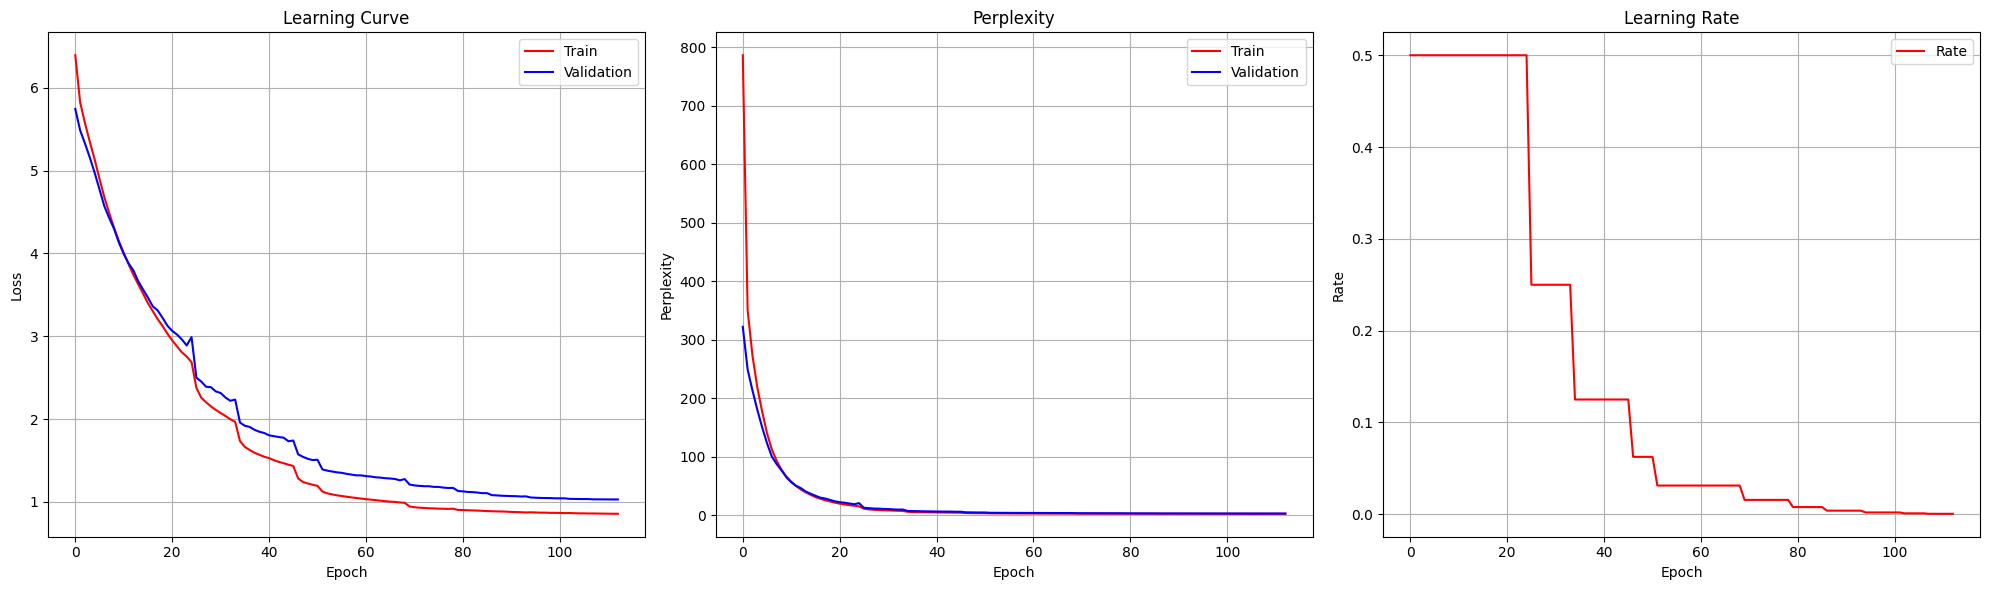

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 1.028 , Perplexity = 2.847
Test: Loss = 1.004 , Perplexity = 2.782


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

In [22]:
num_trainable_params(model)

34.825785

In [27]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie of west was preparing goals like a the black difficulty of dying .
